# Extracting Kinect features from data gathered from Kinect V1

In [1]:
import numpy as np
from numpy import genfromtxt
from math import sqrt
import csv
import matplotlib.pyplot as plt

## Get data from csv file
The next line code will save all the data in a numpy array with their header names

In [2]:
kinect_data = np.genfromtxt('F001.g1.s1.i1.csv', delimiter=',', names = True, dtype=None)

Our data is structured as follows:
* One row contains `Frame`, `Time_Stamp`, `FPS_Location_ms`, `SkelId`, `Joint_Type`, `Confidence`, `X`, `Y`, `Original_Position_X`, `Original_Position_Y`, `Original_Position_Z` columns.
* Every 20 rows represents a frame.
* The `Joint_Type` column has the one name of the joints (per row).
* 20 Joints were saved for each skeleton
* `X` and `Y` values are from kinect coordintates.


In [3]:
print(kinect_data.dtype.names)

('Frame', 'Time_Stamp', 'FPS_Location_ms', 'SkelId', 'Joint_Type', 'Confidence', 'X', 'Y', 'Original_Position_X', 'Original_Position_Y', 'Original_Position_Z')


For our analysis, we are going to select `Joint_Type`, `X` and `Y` columns.

## Changing the skeleton reference and selecting upper limbs joints
In order to ease the analysis of skeletons, we are going to change the kinect reference into the screen reference.
For our analysis we are going to include only upper limbs joints: 

| **Joints**    | **Joints**    |
| ------------- |:-------------:|
| Spine         | HipCenter     |
| ShoulderLeft  | ShoulderRight |
| ElbowLeft     | ElbowRight    |
| WristLeft     | WristRight    |
| ShoulderCenter     |

One additional consideration of our analysis is that we use the wrist as the hand reference, due to the noise that Kinect produces, giving an innacurate joint recognition of the hand.

In [4]:
joint_types = [b'Spine',b'HipCenter',b'ShoulderLeft',b'ShoulderCenter',b'ElbowLeft',b'WristLeft',b'ShoulderRight',b'ElbowRight',b'WristRight']

In [5]:
#change reference from skeleton data to screen reference
def changeReference(sk):
	skeleton = {} 
	initialpos = []
	origin = []
#find the center of skeleton (ShoulderCenter)
	ind = np.where(sk['Joint_Type'] == b'ShoulderCenter')
	skeleton.update({b'ShoulderCenter':[0,0]})
	origin = [int(sk['X'][ind]),-int(sk['Y'][ind])]
	initialpos.extend(origin)
	joint_types = [b'Spine',b'HipCenter',b'ShoulderLeft',b'ElbowLeft',b'ElbowLeft',b'WristLeft',b'ShoulderRight',b'ElbowRight',b'WristRight']
	for i in range(20):
		if skeleton_frame['Joint_Type'][i] in joint_types:
			initialpos.extend([sk['X'][i],sk['Y'][i]])
			skeleton.update({sk['Joint_Type'][i]:[sk['X'][i]-origin[0],-sk['Y'][i]-origin[1]]})
	return skeleton

## Get a skeleton frame
According to the structure of the file, we need to save a skeleton every 20 rows:

In [6]:
#save all skeleton frames
skeletons = []

for i in range(0,len(kinect_data),20):
    skeleton_frame = kinect_data[['Joint_Type', 'Confidence', 'X', 'Y']][i:i+21]
    
    #change to screen reference
    skeleton = changeReference(skeleton_frame)
    
    #add the skeleton to the list of all skeleton frames
    skeletons.append(skeleton)
print(len(skeletons))

3530


## Drawing a Skeleton
To have an idea in how the points are being saved, we draw a skeleton.

First, we create a list of points.

In [7]:
#create points for plotting the skeleton
skeletons_points = []
for i in range(len(skeletons)):
    skeleton_points= []
    skeleton_points.append([skeletons[i][b'ShoulderCenter'],skeletons[i][b'Spine']])
    skeleton_points.append([skeletons[i][b'ShoulderCenter'],skeletons[i][b'ShoulderLeft']])
    skeleton_points.append([skeletons[i][b'ShoulderCenter'],skeletons[i][b'ShoulderRight']])
    skeleton_points.append([skeletons[i][b'Spine'],skeletons[i][b'HipCenter']])
    skeleton_points.append([skeletons[i][b'ShoulderLeft'],skeletons[i][b'ElbowLeft']])
    skeleton_points.append([skeletons[i][b'ElbowLeft'],skeletons[i][b'WristLeft']])
    skeleton_points.append([skeletons[i][b'ShoulderRight'],skeletons[i][b'ElbowRight']])
    #skeleton_points.append([skeletons[i][b'ElbowRight'],skeletons[i][b'WristRight']])
    skeletons_points.append(skeleton_points)

Then, we draw the points by converting them into lines and adding to a plot.

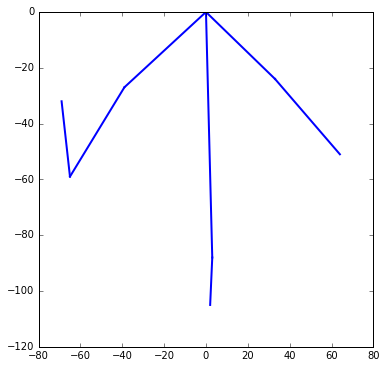

In [10]:
#draw a skeleton
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.lines import Line2D 
%matplotlib inline

fig, ax = plt.subplots()

fig.set_size_inches(6,6)          # Make graph square


# Note that the Line2D takes a list of x values and a list of y values,
# not 2 points as one might expect.  So we have to convert our points
# an x-list and a y-list.
sk_lines = []
for points in skeletons_points[900]: #take only the first skeleton
    sk_lines.append(zip(*points))

for points in sk_lines:
    (line_xs,line_ys) = points
    ax.add_line(Line2D(line_xs,line_ys, linewidth=2, color='blue'))
plt.plot()
plt.show()


## Feature extraction
The features can be calculated either for each skeleton or for all skeletons, depending on what we need to extract.

### 1. Distances

In this type of features, we are going to calculate distances between points. To do this, we use the euclidean distance from two points. 

In [9]:
def euclidean(x,y):
	sumSq=0.0
    
	#add up the squared differences
	for i in range(len(x)):
		sumSq+=(x[i]-y[i])**2
        
	#take the square root of the result
	return (sqrt(sumSq))

#### Distance between hands:

In [10]:
#feature 1: distance between hands:
distBetweenHands = euclidean(skeletons[0][b'WristRight'],skeletons[0][b'WristLeft'])
print(distBetweenHands)

47.51841748206689


#### Distance from spine to the left hand:

In [11]:
#feature 2: distance from  spine to left hand
distSpine2LH = euclidean(skeletons[0][b'Spine'],skeletons[0][b'WristLeft'])
print(distSpine2LH)

66.70832032063167


#### Distance from spine to the right hand:

In [12]:
#feature 3: distance from  spine to right hand
distSpine2RH = euclidean(skeletons[0][b'Spine'],skeletons[0][b'WristRight'])
print(distSpine2RH)

19.697715603592208


#### Distance from spine to the left elbow:

In [13]:
#feature 4: distance from spine to left elbow
distSpine2LE = euclidean(skeletons[0][b'Spine'],skeletons[0][b'ElbowLeft'])
print(distSpine2LE)

66.64082832618455


#### Distance from spine to the right elbow:

In [14]:
#feature 4: distance from spine to right elbow
distSpine2RE = euclidean(skeletons[0][b'Spine'],skeletons[0][b'ElbowRight'])
print(distSpine2RE)

43.174066289845804


### 2. Instant Velocity
To get instant velocity, we need to consider the actual and the next skeleton.

In [15]:
#get velocity from left hand
print(skeletons[0][b'WristLeft'],skeletons[1][b'WristLeft'])
v_xy = np.array(skeletons[0][b'WristLeft'])-np.array(skeletons[1][b'WristLeft'])
print(v_xy)

[-71, -70] [-74, -66]
[ 3 -4]


In [16]:
#get velocity frame 
from math import hypot
v_frame = hypot(v_xy[0],v_xy[1])
print(v_frame)

5.0


### 3. Quantity of Motion

One interesting feature that could show the behavior of a person is the quatity of motion. It has been defined as the
cumulative average of velocity.
For this feature we need:
* Calculate velocity mean every 30 frames.
* Accumuate velocity mean during all presentation.

#### Save all velocity frames from left hand in an array

In [20]:
#save all velocity frames from left hand
v_frames = [0]
for i in range(len(skeletons)-1):
    v_xy = np.array(skeletons[i][b'WristLeft'])-np.array(skeletons[i+1][b'WristLeft'])
    v_frame = hypot(v_xy[0],v_xy[1])
    v_frames.append(v_frame)

#### Calculate velocity mean every 30 frames

In [21]:
fps = 30
velocity_mean = []
for i in range(0,len(v_frames),fps):
    velocity_mean.append(np.array(v_frames[i+1:i+fps+1]).sum()/fps)
print(len(velocity_mean))

118


#### Accumulate velocity mean

In [22]:
qom = np.array(velocity_mean).sum()
print(qom)

593.217467296


We can perform the same calculation for relevant joints.

## Putting all together

From these features, we are going to generate two different files. 
* **A file with all skeleton positions:** With this data we are going to find common postures from this student.
* **A file with overall features like `qom`, `overall_mean_velocity`, `overall_max_velocity`, `overall_min_velocity` for each joint:** From this data, we might want to find an overall assessment per student.

### All skeleton positions

In [23]:
resultFile = open("F001.g1.s1.i1.skeletons.csv",'w')
wr = csv.writer(resultFile, dialect='excel')
header = []
print(skeletons[0].keys())
for key in skeletons[0].keys():
    header.append(key.decode("utf-8")+"_X")
    header.append(key.decode("utf-8")+"_Y")
wr.writerow(header)

# for each skeleton, get all joint values and add to a list, then write a row
for skeleton in skeletons:
    row = []
    for key,value in skeleton.items():
        for point in value:
            row.append(int(point))
    wr.writerow(row)
resultFile.close()

dict_keys([b'ShoulderCenter', b'HipCenter', b'Spine', b'ShoulderLeft', b'ElbowLeft', b'WristLeft', b'ShoulderRight', b'ElbowRight', b'WristRight'])


### Overall features

#### Average distance between hands

In [24]:
distBetweenHands = np.array([euclidean(skeletons[i][b'WristRight'],skeletons[i][b'WristLeft']) for i in range(len(skeletons))])
avg_distBetweenHands = np.mean(distBetweenHands)
print(avg_distBetweenHands)

78.0932892459


#### Minimum distance between hands

In [25]:
min_distBetweenHands = np.min(distBetweenHands)
print(min_distBetweenHands)

0.0


#### Maximum distance between hands

In [26]:
max_distBetweenHands = np.max(distBetweenHands)
print(max_distBetweenHands)

248.652367775


#### Average distance from spine to the left hand:

In [27]:
distSpine2LH = np.array([euclidean(skeletons[i][b'Spine'],skeletons[i][b'WristLeft']) for i in range(len(skeletons))])
avg_distSpine2LH = np.mean(distSpine2LH)
print(avg_distSpine2LH)

61.9453420729


#### Average distance from spine to the right hand:

In [28]:
distSpine2RH = np.array([euclidean(skeletons[i][b'Spine'],skeletons[i][b'WristRight']) for i in range(len(skeletons))])
avg_distSpine2RH = np.mean(distSpine2RH)
print(avg_distSpine2RH)

45.033238328


#### Average distance from spine to the left elbow:

In [29]:
distSpine2LE = np.array([euclidean(skeletons[i][b'Spine'],skeletons[i][b'ElbowLeft']) for i in range(len(skeletons))])
avg_distSpine2LE = np.mean(distSpine2LE)
print(avg_distSpine2LE)

57.1922896718


#### Average distance from spine to the right elbow:

In [30]:
distSpine2RE = np.array([euclidean(skeletons[i][b'Spine'],skeletons[i][b'ElbowRight']) for i in range(len(skeletons))])
avg_distSpine2RE = np.mean(distSpine2RE)
print(avg_distSpine2RE)

53.2060035082


#### QoM of all joints

In [31]:
#save all velocity frames from all joints
all_velocity_frames = []
for joint in joint_types:
    v_frames = [0]
    for i in range(len(skeletons)-1):
        v_xy = np.array(skeletons[i][joint])-np.array(skeletons[i+1][joint])
        v_frames.append(hypot(v_xy[0],v_xy[1]))
    all_velocity_frames.append(v_frames)
    

#### Calculate velocity mean for all joints every 30 frames

In [32]:
fps = 10
all_velocity_mean = []
for vf in all_velocity_frames:
    velocity_mean = []
    for i in range(0,len(vf),fps):
        velocity_mean.append((np.array(vf[i+1:i+fps+1]).sum())/fps)
    all_velocity_mean.append(velocity_mean)


#### Accumulate velocity mean

In [33]:
QoM = []
for i,velocity_mean in enumerate(all_velocity_mean):
    QoM.append(np.array(velocity_mean).sum())
    print(joint_types[i],np.array(velocity_mean).sum())

b'Spine' 367.525720454
b'HipCenter' 406.875900919
b'ShoulderLeft' 488.827613004
b'ShoulderCenter' 0.0
b'ElbowLeft' 831.681086646
b'WristLeft' 1779.65240189
b'ShoulderRight' 400.044798317
b'ElbowRight' 676.30404517
b'WristRight' 1656.89929664


#### Save all features

In [34]:
overallFile = open("overall_features.csv",'w')
wr = csv.writer(overallFile, dialect='excel')
header = ["avg_distBetweenHands","min_distBetweenHands","max_distBetweenHands","avg_distSpine2LH","avg_distSpine2RH","avg_distSpine2LE","avg_distSpine2RE"]
for joint in joint_types:
    header.append("QoM_"+joint.decode("utf-8"))
wr.writerow(header)
row = [avg_distBetweenHands,min_distBetweenHands,max_distBetweenHands,avg_distSpine2LH,avg_distSpine2RH,avg_distSpine2LE,avg_distSpine2RE]
for i in range(len(joint_types)):
    row.append(QoM[i])
wr.writerow(row)
overallFile.close()